In [ ]:
# @inproceedings{barbieri-etal-2020-tweeteval,
#     title = "{T}weet{E}val: Unified Benchmark and Comparative Evaluation for Tweet Classification",
#     author = "Barbieri, Francesco  and
#       Camacho-Collados, Jose  and
#       Espinosa Anke, Luis  and
#       Neves, Leonardo",
#     booktitle = "Findings of the Association for Computational Linguistics: EMNLP 2020",
#     month = nov,
#     year = "2020",
#     address = "Online",
#     publisher = "Association for Computational Linguistics",
#     url = "https://aclanthology.org/2020.findings-emnlp.148",
#     doi = "10.18653/v1/2020.findings-emnlp.148",
#     pages = "1644--1650"
# }

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

from sklearn.feature_extraction.text import TfidfVectorizer

/home/hugohdezm/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-07 11:39:43.616579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736249983.695619    4959 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736249983.715036    4959 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 11:39:43.873921: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performanc

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
dataset = pd.read_csv('raw_dataset.csv')
dataset

,text,labels
0,My favourite food is anything I didn't have to...,4
1,"Now if he does off himself, everyone will thin...",4
2,WHY THE FUCK IS BAYLESS ISOING,0
3,To make her feel threatened,2
4,Dirty Southern Wankers,0
...,...,...
44518,Thanks. I was diagnosed with BP 1 after the ho...,3
44519,Well that makes sense.,3
44520,Daddy issues [NAME],4
44521,So glad I discovered that subreddit a couple m...,3


In [ ]:
train_data, test_data = train_test_split(dataset, test_size=0.1, stratify=dataset['labels'], random_state=42)

# Subdividimos train en el propio train y datos para la validación
train_data, validation_data = train_test_split(train_data, test_size=0.2, stratify=train_data['labels'], random_state=3)

In [ ]:
print(train_data.head())
print(validation_data.head())
print(test_data.head())

                                                    text  labels
27409  We've allways a ear to rent you here in reddit...       3
13991  No, you are just suggesting someone be at the ...       4
7351   😂😂 she really is. I can’t stop laughing. She’s...       3
21022     You first! Make it more interesting than this!       6
5217          I guess you’ve become something of an icon       4
                                                    text  labels
28161                            Definitely bitter, lol.       3
21371                                     I just see yes       3
8280   > I just don't see how this movie wouldn't get...       0
19138        Get your nose hair waxed. Trust me on this.       3
16476     How come you shock the spinach in an ice bath?       6
                                                    text  labels
4999   Dear down voter, go to your own sub and take y...       0
33829  He's shooting very efficiently, too. Most of h...       3
5526   I feel like I'm in

In [ ]:
train_dataset = Dataset.from_pandas(train_data)
validation_dataset = Dataset.from_pandas(validation_data)
test_dataset = Dataset.from_pandas(test_data)

huggingface_dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

huggingface_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 32056
    })
    validation: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 8014
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 4453
    })
})

In [ ]:
checkpoint = 'cardiffnlp/twitter-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_datasets = huggingface_dataset.map(tokenize_function, batched=True)
tokenized_datasets.column_names

Map: 100%|██████████| 4453/4453 [00:00<00:00, 15829.60 examples/s]


{'train': ['text',
  'labels',
  '__index_level_0__',
  'input_ids',
  'attention_mask'],
 'validation': ['text',
  'labels',
  '__index_level_0__',
  'input_ids',
  'attention_mask'],
 'test': ['text',
  'labels',
  '__index_level_0__',
  'input_ids',
  'attention_mask']}

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(['text', '__index_level_0__'])
tokenized_datasets = tokenized_datasets.with_format('tensorflow')
tokenized_datasets['train']

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 32056
})

In [ ]:
train_dataset = tokenized_datasets['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask',],
    label_cols=['labels'],
    shuffle=True,
    batch_size=8)

validation_dataset = tokenized_datasets['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['labels'],
    shuffle=True,
    batch_size=8)

test_dataset = tokenized_datasets['test'].to_tf_dataset(
columns=['input_ids', 'attention_mask'],
label_cols=['labels'],
shuffle=False,
batch_size=8)

/home/hugohdezm/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
import transformers
from transformers import AdamWeightDecay

checkpoint = 'cardiffnlp/twitter-roberta-base'
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=7)

num_epochs = 3
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

model.compile(optimizer=optimizer, loss=loss, metrics=['sparse_categorical_accuracy'])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=num_epochs,
  steps_per_epoch=len(train_dataset),
  validation_steps=len(validation_dataset)
)

Epoch 1/3
4007/4007 [==============================] - 2223s 553ms/step - loss: 0.8627 - sparse_categorical_accuracy: 0.6794 - val_loss: 0.7971 - val_sparse_categorical_accuracy: 0.7014
Epoch 2/3
4007/4007 [==============================] - 2176s 543ms/step - loss: 0.6656 - sparse_categorical_accuracy: 0.7517 - val_loss: 0.8123 - val_sparse_categorical_accuracy: 0.6942
Epoch 3/3
4007/4007 [==============================] - 2197s 548ms/step - loss: 0.5057 - sparse_categorical_accuracy: 0.8156 - val_loss: 0.9219 - val_sparse_categorical_accuracy: 0.6832


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


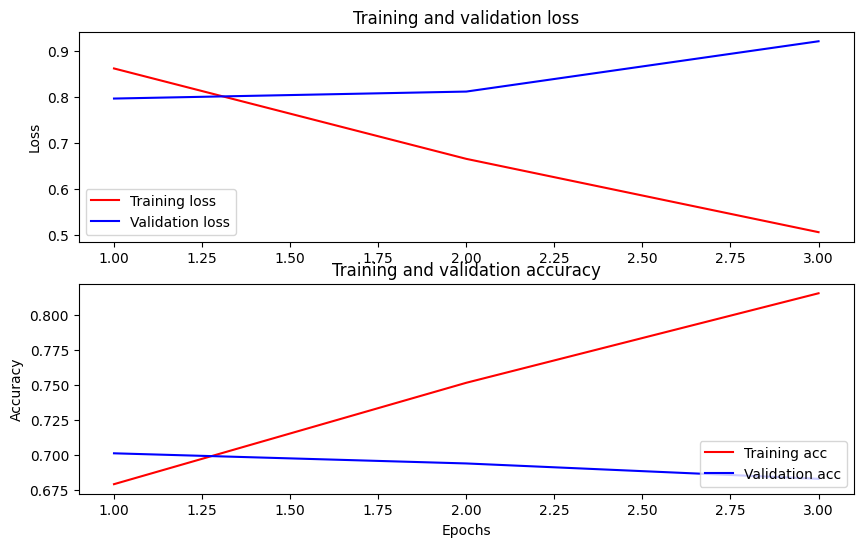

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'feelnet-ROBERTA-3-raw'
saved_model_path = './{}_huggingface'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=True)

INFO:tensorflow:Assets written to: ./feelnet-ROBERTA-3-raw_huggingface/assets


INFO:tensorflow:Assets written to: ./feelnet-ROBERTA-3-raw_huggingface/assets


In [ ]:
model.save_pretrained('./roberta_3_raw_finetuned_model')
tokenizer.save_pretrained('./roberta_3_raw_finetuned_model')

('./roberta_3_raw_finetuned_model/tokenizer_config.json',
 './roberta_3_raw_finetuned_model/special_tokens_map.json',
 './roberta_3_raw_finetuned_model/vocab.json',
 './roberta_3_raw_finetuned_model/merges.txt',
 './roberta_3_raw_finetuned_model/added_tokens.json',
 './roberta_3_raw_finetuned_model/tokenizer.json')

In [ ]:
print(saved_model_path)

./feelnet-ROBERTA-3-raw_huggingface


In [ ]:
## Recuperar el modelo guardado con model.save
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
## Recuperar el modelo guardado con save_pretrained
reloaded_tokenizer = AutoTokenizer.from_pretrained('./roberta_3_new_finetuned_model')
reloaded_model = TFAutoModelForSequenceClassification.from_pretrained('./roberta_3_new_finetuned_model')